# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import logging

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()

MLFLOW_S3_ENDPOINT_URL = "https://storage.yandexcloud.net"
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
S3_BUCKET_NAME = os.getenv('S3_BUCKET_NAME')

In [3]:
# создаём S3-клиент
import boto3

s3 = boto3.client(
    "s3",
    endpoint_url=MLFLOW_S3_ENDPOINT_URL,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [4]:
tracks = pd.read_parquet("tracks.parquet")
catalog_names = pd.read_parquet("catalog_names.parquet")
interactions = pd.read_parquet("interactions.parquet")

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [12]:
print("--------- Tracks Info:")
tracks.info()
print("\n--------- Catalog_names Info:")
catalog_names.info()
print("\n--------- Interactions Info:")
interactions.info()

--------- Tracks Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB

--------- Catalog_names Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB

--------- Interactions Info:
<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   i

In [20]:
print(interactions[["user_id", "track_id", "started_at", "track_seq"]].sample(5, random_state=52).sort_values("user_id").set_index(["user_id", "track_seq"]).to_string())

                   track_id started_at
user_id track_seq                     
46179   37         29544272 2022-11-23
70117   1055       28213677 2022-09-18
72819   270        85090862 2022-08-08
471152  18            55682 2022-09-10
688081  211          220497 2022-02-22


In [15]:
tracks.sample(3).T

,121259,124414,650583
track_id,2190993,2214833,45838742
albums,"[216815, 8828290, 13888175, 17134314]",[63387],"[6161725, 8854149]"
artists,[4029],[41110],[4435372]
genres,"[26, 74]","[11, 20]",[11]


In [16]:
catalog_names.sample(3).T

,511549,299,361165
id,11574627,666,6207395
type,album,album,album
name,Gerek,Sabotage,На самокате


In [17]:
interactions.sample(3).T

,788,76,1
user_id,871257,1133456,59724
track_id,50868869,79791789,1535858
track_seq,789,77,2
started_at,2022-10-17 00:00:00,2022-10-22 00:00:00,2022-05-25 00:00:00


In [19]:
print("Пропуски в tracks:")
print(tracks.isna().sum(), "\n")

print("Пропуски в interactions:")
print(interactions.isna().sum(), "\n")

print("Пропуски в catalog_names:")
print(catalog_names.isna().sum(), "\n")

Пропуски в tracks:
track_id    0
albums      0
artists     0
genres      0
dtype: int64 

Пропуски в interactions:
user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64 

Пропуски в catalog_names:
id      0
type    0
name    0
dtype: int64 



In [21]:
# Проверка пересечения данных

missing_tracks = set(interactions.track_id.unique()) - set(tracks.track_id.unique())
len(missing_tracks)

0

In [24]:
# Проверка уникальности и дублирования

tracks.track_id.duplicated().sum()

0

In [32]:
# Проверка корректности списков (albums, artists, genres)

for col in ["albums", "artists", "genres"]:
    is_list = tracks[col].apply(lambda x: isinstance(x, list)).mean()
    all_int_like = tracks[col].apply(
        lambda x: all(isinstance(i, (int, np.integer)) for i in x)
    ).mean()
    print(f"{col}: share of list values        = {is_list:.3f}")
    print(f"{col}: share of int-like elements  = {all_int_like:.3f}")
    print()

albums: share of list values        = 0.000
albums: share of int-like elements  = 1.000

artists: share of list values        = 0.000
artists: share of int-like elements  = 1.000

genres: share of list values        = 0.000
genres: share of int-like elements  = 1.000



In [26]:
# Проверка, что все albums / artists / genres встречаются в catalog_names

all_ids = set(catalog_names.id)
track_album_ids = set(i for lst in tracks.albums for i in lst)
missing_album_ids = track_album_ids - all_ids

In [27]:
# Проверка корректности interactions

interactions.groupby("user_id").track_seq.is_monotonic_increasing.mean()

1.0

In [28]:
#  количество событий на пользователя

inter_count = interactions.groupby("user_id").size()
inter_count.describe()

count    1.373221e+06
mean     1.621224e+02
std      3.512846e+02
min      1.000000e+00
25%      2.300000e+01
50%      5.500000e+01
75%      1.540000e+02
max      1.663700e+04
dtype: float64

In [30]:
# Проверка временных дыр

interactions.started_at.describe()

count      222629898
unique           365
top       2022-11-29
freq         1161811
Name: started_at, dtype: object

In [23]:
# количество уникальных пользователей и треков
n_users = interactions.user_id.nunique()
n_tracks = tracks.track_id.nunique()

print(n_users, n_tracks)

1373221 1000000


Первоначальные исправления:

In [22]:
# Приводим даты к типу date
interactions["started_at"] = interactions["started_at"].dt.date

# Проверяем согласованность track_id
interactions = interactions[interactions.track_id.isin(tracks.track_id)]

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

1. **Типы идентификаторов:**

- user_id и track_id представлены в числовых типах (int32/int64).
- Приведение типов не требуется.

2. **Проверка качества данных:**

- *Tracks:*
    - Нет пропусков.
    - Неизвестных альбомов, артистов и жанров нет, т.к. все значения заполнены.

- *Catalog_names:*
    - Нет пропусков. 
    - Никаких проблем не обнаружено.

- *Interactions:*
    - Более 222 млн событий. 
    - Нет пропусков. 
    - Типы колонок корректны.
    - Дата приведена к типу date (исправление применено).

3. **Проверка пересечения данных:**

- Все события в interactions корректно ссылаются на существующие треки.

4. **Объёмы данных:**

- Пользователей: 1 373 221
- Треков: 1 000 000

**Общее:**

- Даты лежат в пределах 2022 года, без аномальных значений.
- Порядок событий по track_seq внутри пользователя монотонен.
- Все album_ids / artist_ids / genre_ids находятся в catalog_names.
- Дубликатов track_id и id в справочниках не обнаружено.

- **Данные выглядят консистентными и готовы к дальнейшей подготовке и построению рекомендаций.**

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

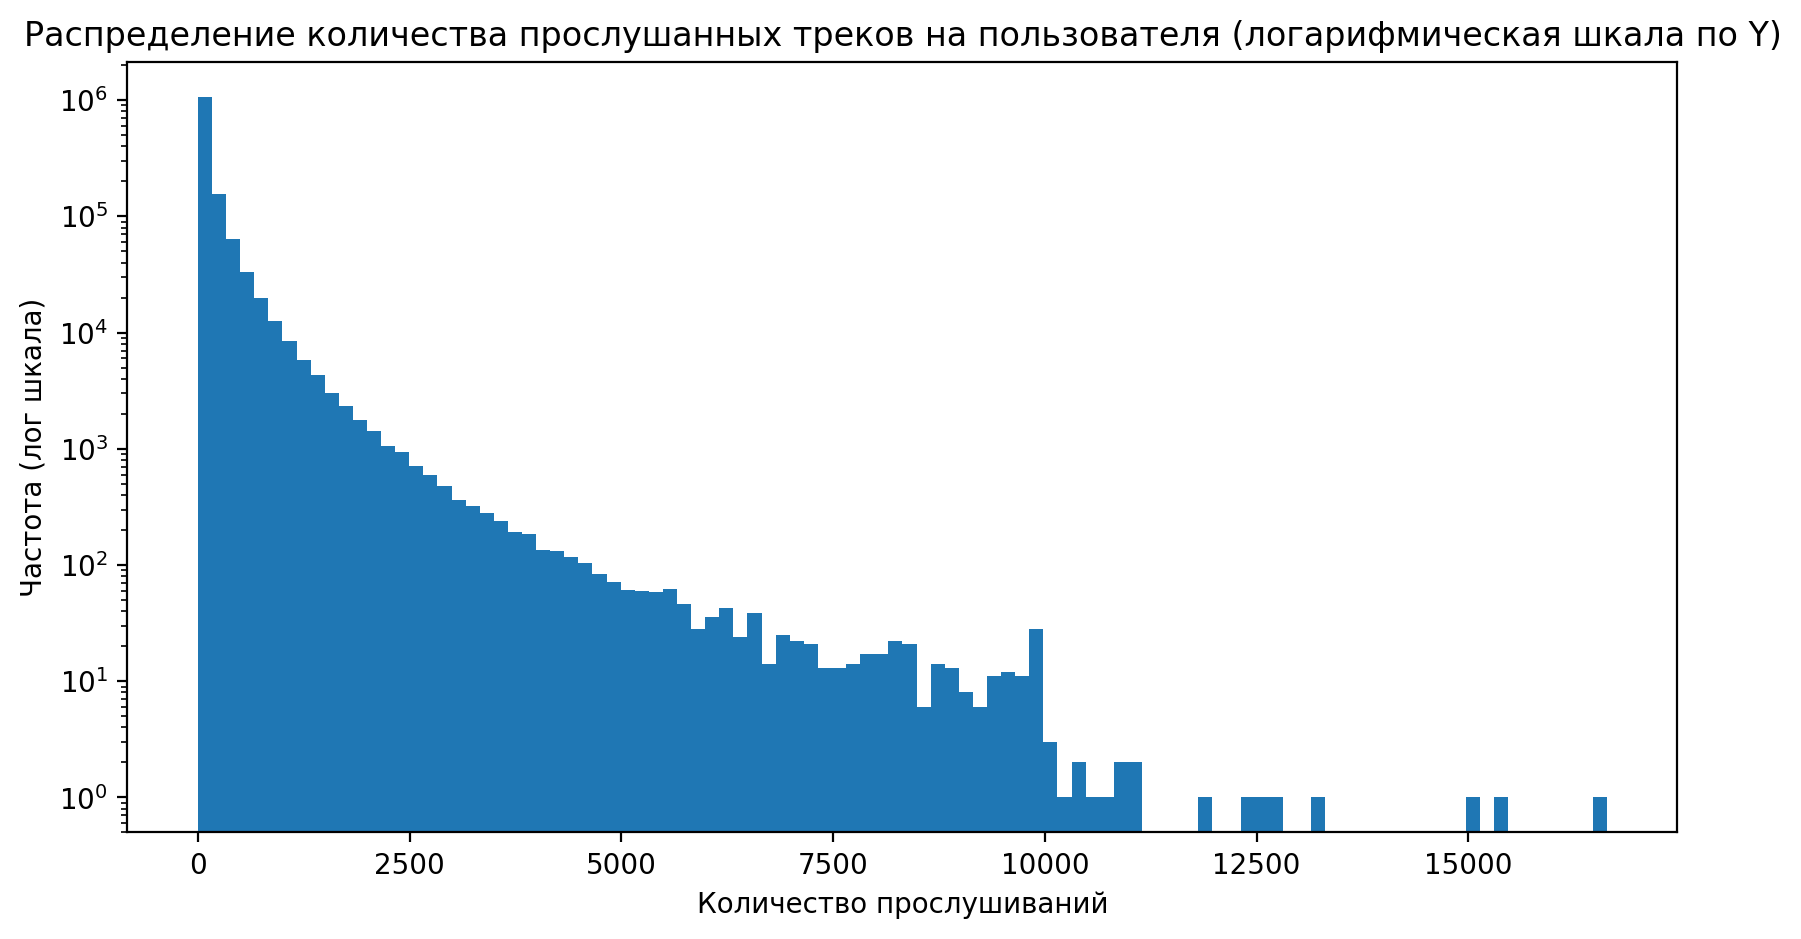

count    1.373221e+06
mean     1.621224e+02
std      3.512846e+02
min      1.000000e+00
25%      2.300000e+01
50%      5.500000e+01
75%      1.540000e+02
max      1.663700e+04
Name: track_id, dtype: float64

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# число прослушиваний на пользователя
user_track_counts = interactions.groupby("user_id").track_id.count()

plt.figure(figsize=(10,5))

# строим гистограмму по значениям
plt.hist(user_track_counts.values, bins=100)
plt.yscale("log")  # логарифмируем ось Y, чтобы хвост было видно

plt.title("Распределение количества прослушанных треков на пользователя (логарифмическая шкала по Y)")
plt.xlabel("Количество прослушиваний")
plt.ylabel("Частота (лог шкала)")
plt.show()

user_track_counts.describe()

Распределение сильно смещено вправо: большинство пользователей совершают относительно мало прослушиваний — медиана 55 событий, первый квартиль около 23, а верхний — около 154.

При этом у небольшой доли пользователей число прослушиваний измеряется тысячами и даже десятками тысяч (максимум — 16 637).

Такое поведение типично для музыкальных сервисов:

- много «лёгких» пользователей с низкой активностью
- мало «силовых слушателей», которые генерируют значительную часть взаимодействий.

Наиболее популярные треки

In [40]:
# среднее число прослушиваний на трек.

track_play_counts = interactions.groupby("track_id").size()
track_play_counts.describe()

count    1000000.000000
mean         222.629898
std         1369.930708
min            5.000000
25%            9.000000
50%           19.000000
75%           67.000000
max       111062.000000
dtype: float64

In [36]:
popular_tracks = (
    interactions.groupby("track_id").size()
    .reset_index(name="plays")
    .sort_values("plays", ascending=False)
)

popular_tracks.head(10)

popular_tracks_named = popular_tracks.merge(
    tracks[["track_id", "artists", "albums", "genres"]], 
    on="track_id", 
    how="left"
)

popular_tracks_named.head(10)

,track_id,plays,artists,albums,genres
0,53404,111062,[9262],"[4367, 89708, 294911, 294912, 294914, 297393, ...","[13, 14, 102]"
1,33311009,106921,[675068],"[4440454, 4456609, 4482682, 4882996, 5072976, ...","[14, 102]"
2,178529,101924,[36800],"[18113, 21924, 21940, 488052, 10009799]","[41, 47]"
3,35505245,99490,"[4611844, 588511]","[4431303, 20559909]","[3, 75]"
4,65851540,86670,[1554548],[10692414],"[11, 20]"
5,24692821,86246,[1194096],"[2888516, 3523463, 3530199, 4333848, 4420934, ...",[70]
6,32947997,85886,[381067],"[4019560, 4172930, 4172931, 5614201, 5933975]",[11]
7,51241318,85244,"[1802873, 3135644, 9012818]","[5239478, 13040087, 13131618, 15177310, 154524...",[74]
8,795836,85042,[680],"[88770, 296297, 297576, 302579, 303469, 558376...","[11, 14, 102]"
9,45499814,84748,[5007577],"[6109461, 7094821, 7152451, 7170954, 7285586, ...","[11, 20]"


Самые популярные треки набирают от ~85 до 110 тысяч прослушиваний, тогда как средний трек получает всего около 200 прослушиваний.

Популярность сконцентрирована вокруг ограниченного набора исполнителей и жанров, что говорит о ярко выраженном «топ-эффекте» в пользовательском поведении.

Наиболее популярные жанры

In [37]:
from collections import Counter

genre_counter = Counter()

for lst in tracks.genres:
    genre_counter.update(lst)

genre_df = (
    pd.DataFrame.from_dict(genre_counter, orient="index", columns=["count"])
    .reset_index().rename(columns={"index": "genre_id"})
    .sort_values("count", ascending=False)
)

genre_df.head(10)

genre_df = genre_df.merge(
    catalog_names[catalog_names.type == "genre"][["id", "name"]],
    left_on="genre_id",
    right_on="id",
    how="left"
).drop(columns="id")

genre_df.head(10)

,genre_id,count,name
0,11,166285,pop
1,75,128212,rap
2,102,118509,allrock
3,68,114245,electronics
4,47,72311,metal
5,3,65958,rusrap
6,44,59778,foreignrap
7,14,55177,rock
8,16,51631,dance
9,20,46707,ruspop


Жанровое распределение также несбалансированно: лидируют pop, rap, allrock, electronics — каждый из них встречается десятки тысяч раз.

Это указывает на то, что жанровые предпочтения аудитории достаточно концентрированы, и небольшая группа жанров покрывает большую часть каталога.

Треки, которые никто не прослушал

In [38]:
played_track_ids = set(interactions.track_id.unique())
all_track_ids = set(tracks.track_id.unique())

unplayed_tracks = all_track_ids - played_track_ids
len(unplayed_tracks)

tracks[tracks.track_id.isin(list(unplayed_tracks))].head()

,track_id,albums,artists,genres


Список непрослушанных треков пуст — все треки из каталога имеют хотя бы одно взаимодействие.

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [45]:
# 1. Базовые датафреймы
items = tracks.copy()
events = interactions.copy()

# 2. Переименовываем track_id → item_id,
#    чтобы дальше работать в общем формате items / events
items = items.rename(columns={"track_id": "item_id"})
events = events.rename(columns={"track_id": "item_id"})

# 3. Гарантируем согласованность item_id:
#    оставляем только события по трекам, которые есть в items
valid_item_ids = set(items["item_id"].unique())
events = events[events["item_id"].isin(valid_item_ids)].copy()

# 4. (разумная фильтрация) Оставляем пользователей с ≥ 2 прослушиваниями
user_counts = events["user_id"].value_counts()
valid_users = user_counts[user_counts >= 2].index
events = events[events["user_id"].isin(valid_users)].copy()

# 5. Сбрасываем индексы для аккуратности
items = items.reset_index(drop=True)
events = events.reset_index(drop=True)

print("Размер items:", items.shape)
print("Размер events:", events.shape)

NameError: name 'tracks' is not defined

In [46]:
events.sample(10).T

,54901770,202010055,23514598,79179678,222122648,159801246,49017174,25969512,65691462,175695885
user_id,338819,1248033,144908,489185,1371557,986192,302875,159834,405782,1085119
item_id,314191,609732,65920674,74718138,71773466,77752022,64114568,23402701,55542987,38217631
track_seq,118,68,472,263,221,1299,305,62,893,30
started_at,2022-08-25,2022-07-03,2022-11-11,2022-09-24,2022-05-31,2022-09-05,2022-12-11,2022-04-05,2022-06-10,2022-05-23


# Сохранение данных

Сохраняем данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [43]:
items.to_parquet("items.parquet")
events.to_parquet("events.parquet")

In [53]:
s3.upload_file(
    Filename="items.parquet",
    Bucket=S3_BUCKET_NAME,
    Key="recsys/data/items.parquet",
)
print("✅ items.parquet в S3: recsys/data/items.parquet")

s3.upload_file(
    Filename="events.parquet",
    Bucket=S3_BUCKET_NAME,
    Key="recsys/data/events.parquet",
)
print("✅ events.parquet в S3: recsys/data/events.parquet")

✅ items.parquet в S3: recsys/data/items.parquet
✅ events.parquet в S3: recsys/data/events.parquet


In [42]:
# “читаемые” названия для EDA
catalog_map = catalog_names.set_index("id")["name"].to_dict()

def decode(lst):
    return [catalog_map.get(i, None) for i in lst]

tracks_with_names = items.copy()
tracks_with_names["album_names"]  = tracks_with_names["albums"].apply(decode)
tracks_with_names["artist_names"] = tracks_with_names["artists"].apply(decode)
tracks_with_names["genre_names"]  = tracks_with_names["genres"].apply(decode)

tracks_with_names.sample(5).T  # для наглядности

,270708,334170,748420,753860,176784
item_id,17113254,21709244,56780718,57384987,4773978
albums,"[1881442, 1901377, 1935331, 2311384, 3044954, ...",[2490323],[8439920],[8628884],"[531634, 1695033, 1702324, 7686076, 12189313, ..."
artists,[154301],[18555],[4079196],[4876799],"[16639, 1084445, 83845, 4074]"
genres,[11],[33],"[3, 75]","[3, 75]","[23, 69]"
album_names,"[Can't Rely on You, A Perfect Contradiction, A...",[Hearts On Fire],[Забытый архив],[Старое-новое],"[50 Greatest Opera Classics, The Opera Album 2..."
artist_names,[Paloma Faith],[Colin James],[Кот Балу],[Sh Kera],"[Luciano Pavarotti, Wiener Volksopernorchester..."
genre_names,[pop],[blues],"[rusrap, rap]","[rusrap, rap]","[classical, classicalmusic]"


# Очистка памяти

Очистка памяти для высвобождения ресурсов, чтобы приступить к следующему этапу. 

In [54]:
os.remove("items.parquet")
os.remove("events.parquet")
os.remove("tracks.parquet")
os.remove("catalog_names.parquet")
os.remove("interactions.parquet")
print("🧹 Локальные parquet-файлы удалены")

🧹 Локальные parquet-файлы удалены


In [44]:
del tracks, interactions, catalog_names

In [55]:
del user_track_counts, genre_counter, genre_df
import gc; gc.collect()

4991

#### Вывод:

Анализ данных показал ожидаемую для музыкальных сервисов картину: активность пользователей распределена крайне неравномерно — большинство слушает мало, тогда как небольшой процент генерирует тысячи событий. Были выявлены ярко выраженные популярные треки и жанры, а непрослушанных треков в датасете нет. Данные очищены, приведены к удобному формату и сохранены в виде items.parquet и events.parquet для дальнейшего построения рекомендательной системы.

Для того, чтобы приступить к этапу 3, необходимо перезапустить kernel, выполнить секции 1-4.

# === ЭТАП 3 ===

# Загрузка данных

Загружаем items.parquet, events.parquet.

In [5]:
import io
import pandas as pd

ITEMS_KEY = "recsys/data/items.parquet"
EVENTS_KEY = "recsys/data/events.parquet"

def load_parquet_from_s3(key: str) -> pd.DataFrame:
    obj = s3.get_object(Bucket=S3_BUCKET_NAME, Key=key)
    buf = io.BytesIO(obj["Body"].read())
    return pd.read_parquet(buf)

items = load_parquet_from_s3(ITEMS_KEY)
events = load_parquet_from_s3(EVENTS_KEY)

print(items.shape, events.shape)

(1000000, 4) (222629049, 4)


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [7]:
# В тренировочную отнесите все данные до 16 декабря 2022 года (не включительно).
import datetime as dt

split_date = dt.date(2022, 12, 16)

events_train = events[events["started_at"] < split_date].copy()
events_test  = events[events["started_at"] >= split_date].copy()

print("Train shape:", events_train.shape)
print("Test shape:", events_test.shape)

print("Train date range:", events_train["started_at"].min(), "→", events_train["started_at"].max())
print("Test  date range:", events_test["started_at"].min(), "→", events_test["started_at"].max())

Train shape: (208730442, 4)
Test shape: (13898607, 4)
Train date range: 2022-01-01 → 2022-12-15
Test  date range: 2022-12-16 → 2022-12-31


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [ ]:
item_popularity = (
    events_train
    .groupby("item_id").size()
    .reset_index(name="plays")
    .sort_values("plays", ascending=False)
)

item_popularity["score"] = item_popularity["plays"].astype(float)

TOP_K = 100
top_popular = item_popularity.head(TOP_K).reset_index(drop=True)

top_popular.head()

,item_id,plays,score
0,53404,110025,110025.0
1,33311009,101075,101075.0
2,178529,100866,100866.0
3,35505245,95523,95523.0
4,24692821,84153,84153.0


In [15]:
TOP_POPULAR_KEY = "recsys/recommendations/top_popular.parquet"

buf = io.BytesIO()
top_popular.to_parquet(buf, index=False)
buf.seek(0)

s3.put_object(Bucket=S3_BUCKET_NAME, Key=TOP_POPULAR_KEY, Body=buf.getvalue())
print("✅ top_popular.parquet сохранён в S3:", TOP_POPULAR_KEY)

✅ top_popular.parquet сохранён в S3: recsys/recommendations/top_popular.parquet


# Персональные

Рассчитаем персональные рекомендации.

In [16]:
# срезаем менее релевантные треки/юзеров, чтобы усорить обучение модели и не словить краш ВМ, сильно не потеряв в качестве рекомендаций

# 0. Берём подмножество пользователей
N_USERS_SAMPLE = 100_000        # если ВМ тяжело — уменьшем до 5_000
MAX_EVENTS_PER_USER = 200      # максимум событий на пользователя

# выбираем случайную подвыборку пользователей
user_sample = (
    events_train["user_id"]
    .drop_duplicates()
    .sample(N_USERS_SAMPLE, random_state=42)
)

events_train_small = (
    events_train[events_train["user_id"].isin(user_sample)]
    .sort_values(["user_id", "started_at"])
    .groupby("user_id")
    .tail(MAX_EVENTS_PER_USER)
    .copy()
)

print("events_train_small shape:", events_train_small.shape)
print("users in small:", events_train_small["user_id"].nunique())
print("items in small:", events_train_small["item_id"].nunique())

# 1. Фильтруем редкие треки
MIN_ITEM_PLAYS = 20

item_plays = events_train_small.groupby("item_id").size()
good_items = item_plays[item_plays >= MIN_ITEM_PLAYS].index

events_train_reduced = events_train_small[
    events_train_small["item_id"].isin(good_items)
].copy()

print(
    "events_train_small:", len(events_train_small),
    "→ reduced:", len(events_train_reduced),
    "| items:", events_train_small["item_id"].nunique(),
    "→", events_train_reduced["item_id"].nunique()
)

# 2. Фильтруем «холодных» пользователей
MIN_USER_EVENTS = 20

user_events = events_train_reduced.groupby("user_id").size()
good_users = user_events[user_events >= MIN_USER_EVENTS].index

events_train_reduced = events_train_reduced[
    events_train_reduced["user_id"].isin(good_users)
].copy()

print(
    "users:", events_train_small["user_id"].nunique(),
    "→", events_train_reduced["user_id"].nunique()
)

events_train_small shape: (8206395, 4)
users in small: 100000
items in small: 544826
events_train_small: 8206395 → reduced: 6580478 | items: 544826 → 61611
users: 100000 → 69394


In [17]:
events_train_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6245575 entries, 3532 to 222628253
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     int32 
 1   item_id     int32 
 2   track_seq   int16 
 3   started_at  object
dtypes: int16(1), int32(2), object(1)
memory usage: 154.9+ MB


In [22]:
import scipy.sparse as sp
from sklearn.preprocessing import LabelEncoder
from implicit.als import AlternatingLeastSquares

# 3. Кодирование id в 0..N-1
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

events_train_enc = events_train_reduced.copy()
events_train_enc["user_id_enc"] = user_encoder.fit_transform(events_train_enc["user_id"])
events_train_enc["item_id_enc"] = item_encoder.fit_transform(events_train_enc["item_id"])

n_users = len(user_encoder.classes_)
n_items = len(item_encoder.classes_)

rows = events_train_enc["user_id_enc"].values
cols = events_train_enc["item_id_enc"].values
data = np.ones(len(events_train_enc), dtype=np.float32)

user_item_matrix_train = sp.coo_matrix(
    (data, (rows, cols)),
    shape=(n_users, n_items)
).tocsr()

print("user_item_matrix_train shape:", user_item_matrix_train.shape)

# 4. Обучаем ALS на user×item (БЕЗ .T)
als_model = AlternatingLeastSquares(
    factors=80,
    regularization=0.01,
    iterations=20,
    num_threads=0,  # все ядра
    random_state=0,
)

als_model.fit(user_item_matrix_train)

user_item_matrix_train shape: (69394, 61608)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.52s/it]


После агрессивного уменьшения объёма данных (100 000 пользователей, не более 200 событий на пользователя, фильтрация редких треков и «холодных» юзеров) удалось сократить матрицу взаимодействий до 69394 пользователей × 61608 треков, не потеряв структуру реального поведения.

Обучение ALS на такой матрице заняло всего ~31 секунду, что делает модель достаточно лёгкой для экспериментов, при этом обеспечивая репрезентативное качество рекомендаций.

In [ ]:
MAX_K = 200  # максимальное число рекомендаций на пользователя

# 1. Список всех закодированных пользователей
n_users = user_item_matrix_train.shape[0]
user_ids_encoded = np.arange(n_users, dtype=np.int32)

# 2. Получаем рекомендации ALS для всех пользователей
als_items_enc, als_scores = als_model.recommend(
    user_ids_encoded,
    user_item_matrix_train, # users × items
    N=MAX_K,
    filter_already_liked_items=False,
)

# 3. Собираем в DataFrame
als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": als_items_enc.tolist(),
    "score": als_scores.tolist(),
})

als_recommendations = als_recommendations.explode(
    ["item_id_enc", "score"],
    ignore_index=True
)

als_recommendations["user_id_enc"] = als_recommendations["user_id_enc"].astype(int)
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype(int)
als_recommendations["score"] = als_recommendations["score"].astype(float)

# 4. Маппим обратно к исходным id
als_recommendations["user_id"] = user_encoder.inverse_transform(
    als_recommendations["user_id_enc"]
)
als_recommendations["item_id"] = item_encoder.inverse_transform(
    als_recommendations["item_id_enc"]
)

als_recommendations = als_recommendations[["user_id", "item_id", "score"]]

als_recommendations.head()

,user_id,item_id,score
0,23,24663745,0.614931
1,23,27254433,0.477611
2,23,26285336,0.453463
3,23,30049955,0.415717
4,23,25995209,0.410869


In [25]:
PERSONAL_ALS_KEY = "recsys/recommendations/personal_als.parquet"

buf = io.BytesIO()
als_recommendations.to_parquet(buf, index=False)
buf.seek(0)
s3.put_object(Bucket=S3_BUCKET_NAME, Key=PERSONAL_ALS_KEY, Body=buf.getvalue())
print("✅ personal_als.parquet сохранён в S3:", PERSONAL_ALS_KEY)

✅ personal_als.parquet сохранён в S3: recsys/recommendations/personal_als.parquet


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [26]:
import numpy as np
import pandas as pd

# количество закодированных айтемов
n_items = len(item_encoder.classes_)
print("n_items:", n_items)

# сколько похожих треков хранить на каждый
MAX_SIMILAR = 50  # можно 20–100, дальше уже избыточно для проекта

item_ids_enc = np.arange(n_items, dtype=np.int32)

sim_ids_enc, sim_scores = als_model.similar_items(
    item_ids_enc,
    N=MAX_SIMILAR + 1
)

# отбрасываем первый столбец (item сам с собой)
sim_ids_enc = sim_ids_enc[:, 1:]      # shape = (n_items, MAX_SIMILAR)
sim_scores  = sim_scores[:, 1:]       # shape = (n_items, MAX_SIMILAR)

# разворачиваем в длинный формат
similar_df = pd.DataFrame({
    "item_id_enc": np.repeat(item_ids_enc, MAX_SIMILAR),
    "sim_item_id_enc": sim_ids_enc.reshape(-1),
    "score": sim_scores.reshape(-1),
})

similar_df["item_id_enc"] = similar_df["item_id_enc"].astype(int)
similar_df["sim_item_id_enc"] = similar_df["sim_item_id_enc"].astype(int)
similar_df["score"] = similar_df["score"].astype(float)

# маппим обратно к исходным идентификаторам
similar_df["item_id_1"] = item_encoder.inverse_transform(similar_df["item_id_enc"])
similar_df["item_id_2"] = item_encoder.inverse_transform(similar_df["sim_item_id_enc"])

similar_df = similar_df[["item_id_1", "item_id_2", "score"]]

similar_df.head()

n_items: 61608


,item_id_1,item_id_2,score
0,376,352917,0.909703
1,376,3047737,0.906641
2,376,628216,0.899611
3,376,609626,0.894712
4,376,55682,0.892216


In [27]:
SIMILAR_KEY = "recsys/recommendations/similar.parquet"

buf = io.BytesIO()
similar_df.to_parquet(buf, index=False)
buf.seek(0)

s3.put_object(
    Bucket=S3_BUCKET_NAME,
    Key=SIMILAR_KEY,
    Body=buf.getvalue()
)

buf.close()
print("✅ similar.parquet отправлен в S3:", SIMILAR_KEY)

✅ similar.parquet отправлен в S3: recsys/recommendations/similar.parquet


Мы рассчитали рекомендации «похожих треков» при помощи ALS-модели: для каждого трека определили набор наиболее близких к нему по поведенному сходству пользователей.Сохранили итоговый датасет в S3 как similar.parquet.

Теперь у системы есть полнофункциональный блок i2i-рекомендаций, который можно использовать и как самостоятельный модуль, и как часть гибридной модели.

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.